### GRU PIPELINE

In [1]:
import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from backend.ml_pipe.data.dataModule.gru.dataModule import DataModule
from backend.ml_pipe.models.gru.model import GRUModel
from backend.ml_pipe.data.database.mongodb import MongoDb
from pytorch_lightning.callbacks import EarlyStopping
import torch


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_latest_metrics_df(log_root="/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_training"):
    # Alle Versionen in log_root auflisten
    versions = [d for d in os.listdir(log_root) if d.startswith("version_")]
    if not versions:
        raise FileNotFoundError(f"Keine Versionen gefunden in {log_root}")
    
    # Höchste Version wählen
    latest_version = sorted(versions, key=lambda x: int(x.split("_")[1]))[-1]
    latest_path = os.path.join(log_root, latest_version, "metrics.csv")
    
    if not os.path.exists(latest_path):
        raise FileNotFoundError(f"metrics.csv nicht gefunden in {latest_path}")
    
    print(f"Verwende Metriken aus: {latest_path}")
    return pd.read_csv(latest_path)

In [3]:
def print_training_summary(csv_logger):
    metrics = get_latest_metrics_df()

    # Nur Zeilen mit gültigem Validation Loss
    valid_rows = metrics[~metrics['val_loss'].isna() & ~metrics['train_loss'].isna()]
    if valid_rows.empty:
        print("Keine gültigen Metriken gefunden.")
        return

    print("\n=== Training Zusammenfassung ===")
    print(f"Anzahl Epochen: {valid_rows['epoch'].nunique()}")
    print(f"Letzter gültiger Train Loss: {valid_rows['train_loss'].iloc[-1]:.4f}")
    print(f"Letzter gültiger Val Loss:   {valid_rows['val_loss'].iloc[-1]:.4f}")
    overfit_ratio = valid_rows['val_loss'].iloc[-1] / valid_rows['train_loss'].iloc[-1]
    print(f"Overfitting Ratio:           {overfit_ratio:.2f}")

In [4]:
def plot_training_metrics(csv_logger):
    metrics = get_latest_metrics_df()

    metrics = metrics.dropna(subset=['step'])

    fig, axs = plt.subplots(2, 1, figsize=(12, 14))

    def safe_plot(ax, x, y, label):
        if y in metrics.columns and metrics[y].notna().sum() > 0:
            sns.lineplot(data=metrics, x=x, y=y, label=label, ax=ax)

    # Plot 1: Loss
    safe_plot(axs[0], 'step', 'train_loss', 'Train Loss')
    safe_plot(axs[0], 'step', 'val_loss', 'Validation Loss')
    axs[0].set_title("Loss Verlauf")
    axs[0].legend()

    # Plot 2: MSE
    safe_plot(axs[1], 'step', 'train_mse', 'Train MSE')
    safe_plot(axs[1], 'step', 'val_mse', 'Validation MSE')
    axs[1].set_title("MSE Verlauf")
    axs[1].legend()


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:root:Dataset split:
INFO:root:- Train:      134279
INFO:root:- Validation: 28774
INFO:root:- Test:       28775
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | gru       | GRU                         | 1.0 M  | train
1 | attention | AttentionLayer              | 66.0 K | train
2 | fc        | Sequential                  | 41.2 K | train
3 | mse_loss  | MSELoss                     | 0      | train
4 | l

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 4197/4197 [02:35<00:00, 27.05it/s, v_num=39, val_loss=1.640, val_mse=1.540, train_loss=2.180, train_mse=2.070]

Metric val_loss improved. New best score: 1.639


Epoch 1: 100%|██████████| 4197/4197 [02:53<00:00, 24.18it/s, v_num=39, val_loss=1.430, val_mse=1.340, train_loss=1.740, train_mse=1.640]

Metric val_loss improved by 0.204 >= min_delta = 0.001. New best score: 1.435


Epoch 3: 100%|██████████| 4197/4197 [02:52<00:00, 24.38it/s, v_num=39, val_loss=1.290, val_mse=1.200, train_loss=1.470, train_mse=1.380]

Metric val_loss improved by 0.141 >= min_delta = 0.001. New best score: 1.294


Epoch 4: 100%|██████████| 4197/4197 [02:40<00:00, 26.13it/s, v_num=39, val_loss=1.250, val_mse=1.160, train_loss=1.390, train_mse=1.290]

Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 1.253


Epoch 5: 100%|██████████| 4197/4197 [02:34<00:00, 27.15it/s, v_num=39, val_loss=1.250, val_mse=1.160, train_loss=1.350, train_mse=1.260]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.245


Epoch 8: 100%|██████████| 4197/4197 [02:36<00:00, 26.82it/s, v_num=39, val_loss=1.220, val_mse=1.130, train_loss=1.300, train_mse=1.210]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 1.220


Epoch 9: 100%|██████████| 4197/4197 [02:34<00:00, 27.19it/s, v_num=39, val_loss=1.210, val_mse=1.130, train_loss=1.280, train_mse=1.200]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 1.214


Epoch 10: 100%|██████████| 4197/4197 [02:34<00:00, 27.21it/s, v_num=39, val_loss=1.210, val_mse=1.120, train_loss=1.270, train_mse=1.190]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.206


Epoch 12: 100%|██████████| 4197/4197 [02:49<00:00, 24.70it/s, v_num=39, val_loss=1.200, val_mse=1.120, train_loss=1.260, train_mse=1.170]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.202


Epoch 18: 100%|██████████| 4197/4197 [02:44<00:00, 25.49it/s, v_num=39, val_loss=1.200, val_mse=1.110, train_loss=1.230, train_mse=1.140]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.197


Epoch 22: 100%|██████████| 4197/4197 [02:40<00:00, 26.11it/s, v_num=39, val_loss=1.200, val_mse=1.110, train_loss=1.210, train_mse=1.120]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.196


Epoch 23: 100%|██████████| 4197/4197 [02:36<00:00, 26.78it/s, v_num=39, val_loss=1.190, val_mse=1.110, train_loss=1.210, train_mse=1.130]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.193


Epoch 24: 100%|██████████| 4197/4197 [02:36<00:00, 26.77it/s, v_num=39, val_loss=1.190, val_mse=1.110, train_loss=1.210, train_mse=1.120]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.191


Epoch 28: 100%|██████████| 4197/4197 [02:39<00:00, 26.25it/s, v_num=39, val_loss=1.190, val_mse=1.100, train_loss=1.210, train_mse=1.120]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.188


Epoch 29: 100%|██████████| 4197/4197 [02:40<00:00, 26.20it/s, v_num=39, val_loss=1.210, val_mse=1.120, train_loss=1.200, train_mse=1.120]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 4197/4197 [02:40<00:00, 26.19it/s, v_num=39, val_loss=1.210, val_mse=1.120, train_loss=1.200, train_mse=1.120]
Verwende Metriken aus: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_training/version_39/metrics.csv
Keine gültigen Metriken gefunden.
Verwende Metriken aus: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_training/version_39/metrics.csv
Modell gespeichert unter: saved_models/gru_model_20250731_114940.pt


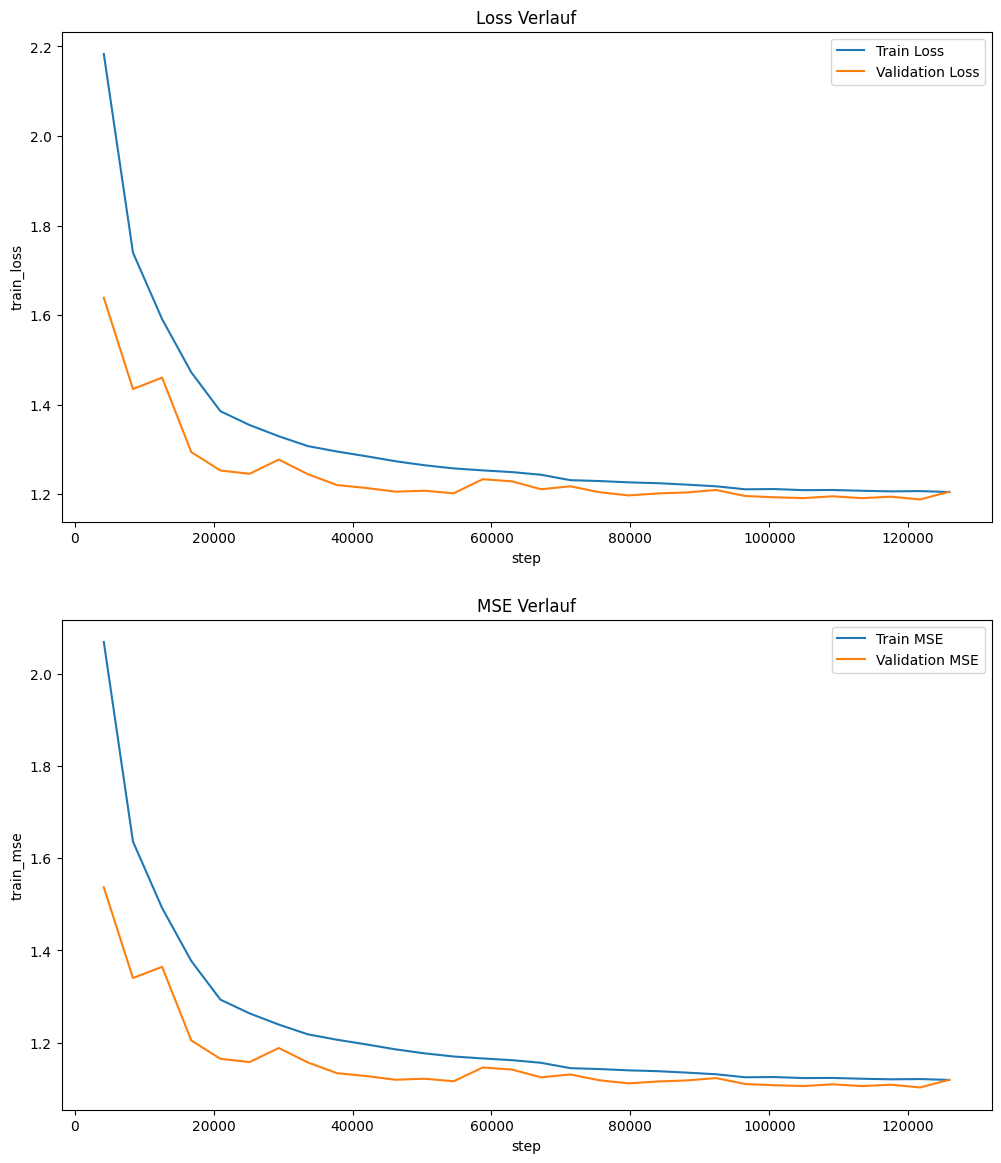

In [5]:
def run_pipeline(max_epochs=30,batch_size=32,hidden_size=128,num_layers=4,dropout=0.2,lr = 0.0003 ,logger_name="gru_training"):
    # Logger
    logger = CSVLogger("lightning_logs", name=logger_name)

    # MongoDB-Client
    mongo_client = MongoDb()

    # DataModule
    data_module = DataModule(mongo_client, batch_size=batch_size)

    # Modell
    model = GRUModel(
        seq_input_size=16,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        lr=lr
    )

    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        patience=7,
        verbose=True,
        mode="min",
        min_delta=0.001
    )

    # Trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        logger=logger,
        accelerator="auto",
        devices=1,
        log_every_n_steps=50,
        callbacks=[early_stop_callback]
    )

    # Training
    trainer.fit(model, datamodule=data_module)

    print_training_summary(logger)

    plot_training_metrics(logger)

    # Modell speichern
    model_path = os.path.join("saved_models", f"gru_model_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.pt")
    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"Modell gespeichert unter: {model_path}")

# Aufruf:
run_pipeline()

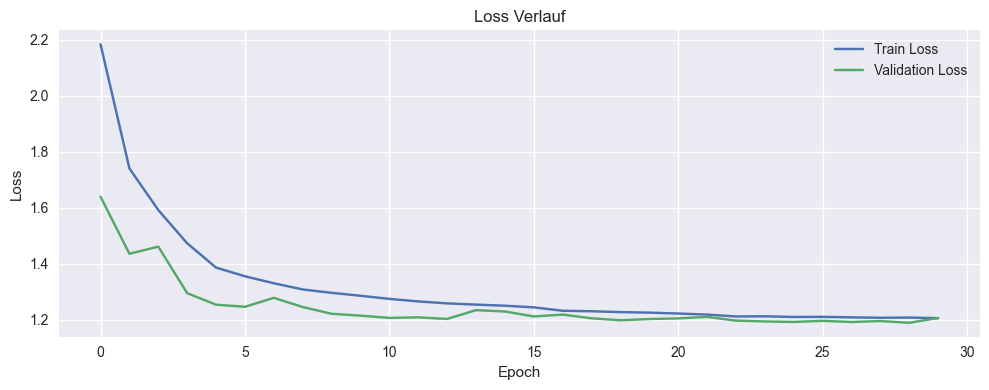

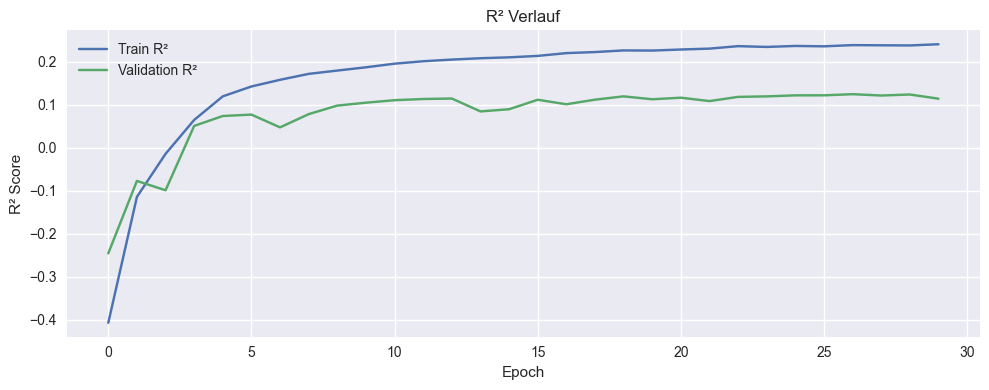

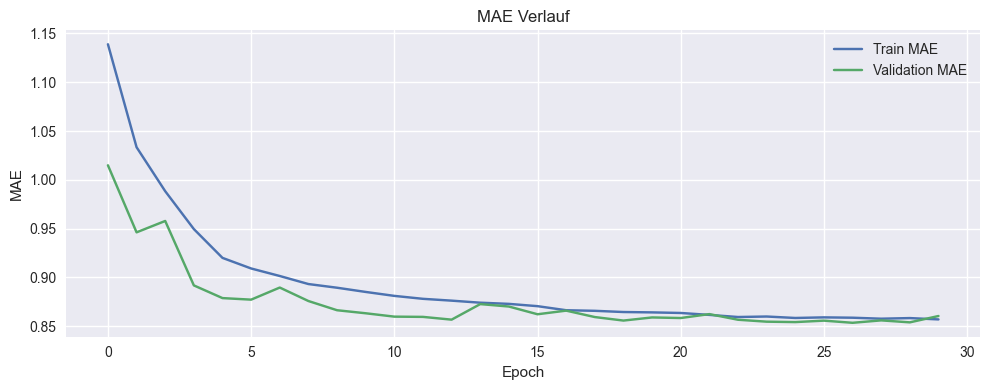

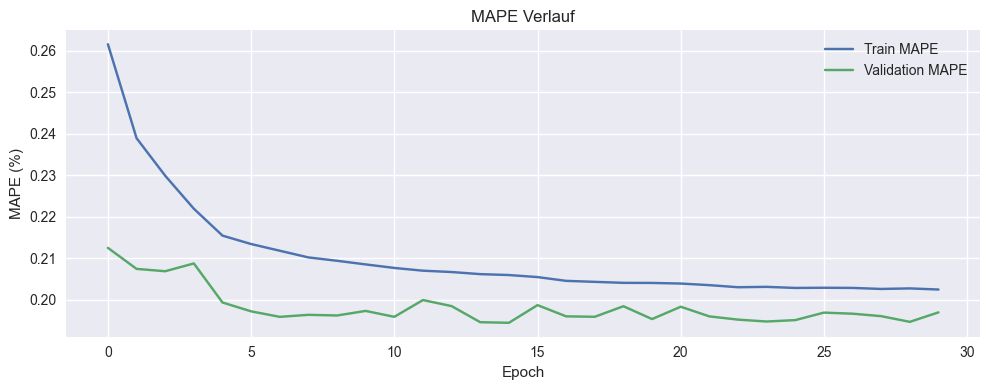

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Datei laden
df = pd.read_csv("/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_training/version_39/metrics.csv")  # Pfad ggf. anpassen
df_clean = df.groupby("epoch").agg("first").reset_index()
plt.style.use("seaborn-v0_8")

plt.figure(figsize=(10, 4))
plt.plot(df_clean["epoch"], df_clean["train_loss"], label="Train Loss")
plt.plot(df_clean["epoch"], df_clean["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Verlauf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_clean["epoch"], df_clean["train_r2"], label="Train R²")
plt.plot(df_clean["epoch"], df_clean["val_r2"], label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² Verlauf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_clean["epoch"], df_clean["train_mae"], label="Train MAE")
plt.plot(df_clean["epoch"], df_clean["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE Verlauf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(df_clean["epoch"], df_clean["train_mape"], label="Train MAPE")
plt.plot(df_clean["epoch"], df_clean["val_mape"], label="Validation MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE (%)")
plt.title("MAPE Verlauf")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
def get_final_scores(csv_path):
    import pandas as pd
    
    # CSV laden
    df = pd.read_csv(csv_path)
    
    # Metriken pro Epoch zusammenfassen
    epoch_summary = []
    for epoch in df['epoch'].unique():
        epoch_data = df[df['epoch'] == epoch]
        
        # Trainings-Metriken
        train_data = epoch_data[epoch_data['train_loss'].notna()]
        # Validierungs-Metriken  
        val_data = epoch_data[epoch_data['val_loss'].notna()]
        
        if not train_data.empty and not val_data.empty:
            summary = {
                'epoch': epoch,
                'train_loss': train_data['train_loss'].iloc[0],
                'val_loss': val_data['val_loss'].iloc[0],
                'train_mae': train_data['train_mae'].iloc[0],
                'val_mae': val_data['val_mae'].iloc[0],
                'train_mse': train_data['train_mse'].iloc[0],
                'val_mse': val_data['val_mse'].iloc[0],
                'train_r2': train_data['train_r2'].iloc[0],
                'val_r2': val_data['val_r2'].iloc[0]
            }
            epoch_summary.append(summary)
    
    summary_df = pd.DataFrame(epoch_summary)
    
    # Letzte Werte
    final = summary_df.iloc[-1]
    print(f"Finale Scores (Epoch {final['epoch']:.0f}):")
    print(f"Train Loss: {final['train_loss']:.4f}")
    print(f"Val Loss:   {final['val_loss']:.4f}")
    print(f"Train MAE:  {final['train_mae']:.4f}")
    print(f"Val MAE:    {final['val_mae']:.4f}")
    print(f"Train MSE:  {final['train_mse']:.4f}")
    print(f"Val MSE:    {final['val_mse']:.4f}")
    print(f"Train R²:   {final['train_r2']:.4f}")
    print(f"Val R²:     {final['val_r2']:.4f}")
    
    # Beste Werte
    best_val_loss = summary_df.loc[summary_df['val_loss'].idxmin()]
    best_val_r2 = summary_df.loc[summary_df['val_r2'].idxmax()]
    
    print(f"\nBeste Val Loss: {best_val_loss['val_loss']:.4f} (Epoch {best_val_loss['epoch']:.0f})")
    print(f"Beste Val R²:   {best_val_r2['val_r2']:.4f} (Epoch {best_val_r2['epoch']:.0f})")
    
    return summary_df

get_final_scores("/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/lightning_logs/gru_training/version_39/metrics.csv")

Finale Scores (Epoch 29):
Train Loss: 1.2049
Val Loss:   1.2055
Train MAE:  0.8570
Val MAE:    0.8605
Train MSE:  1.1191
Val MSE:    1.1194
Train R²:   0.2410
Val R²:     0.1143

Beste Val Loss: 1.1882 (Epoch 28)
Beste Val R²:   0.1249 (Epoch 26)


,epoch,train_loss,val_loss,train_mae,val_mae,train_mse,val_mse,train_r2,val_r2
0,0,2.183068,1.638563,1.138844,1.014893,2.069182,1.537074,-0.407019,-0.245471
1,1,1.739563,1.434821,1.033399,0.946220,1.636226,1.340198,-0.114128,-0.076920
2,2,1.590928,1.460278,0.988349,0.957870,1.492091,1.364491,-0.014030,-0.098723
3,3,1.472211,1.293973,0.949571,0.891885,1.377258,1.204784,0.064949,0.051047
4,4,1.385304,1.252860,0.920061,0.878876,1.293298,1.164971,0.119817,0.074102
5,5,1.354413,1.245494,0.909211,0.877284,1.263494,1.157765,0.142783,0.077358
6,6,1.329420,1.277398,0.901506,0.889676,1.239273,1.188429,0.158293,0.047616
7,7,1.307370,1.244628,0.893267,0.875881,1.218042,1.157040,0.172092,0.078424
8,8,1.295272,1.220399,0.889495,0.866446,1.206321,1.133754,0.179796,0.098318
9,9,1.284777,1.213913,0.885182,0.863337,1.196259,1.127579,0.187366,0.105051


In [1]:
import sys
import json
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.models.gru.predict import predict

# LinkedIn Profildaten als Raw-String (beachte das 'r' vor dem String)
linkedin_data_str = r'''{"skills":["Multitasking","Kundenservice","Interpersonelle Fähigkeiten","Kaltakquise","Hubspot CRM","Customer-Relationship-Management (CRM)"],"firstName":"Darya","lastName":"Chernuska","profilePicture":"https://media.licdn.com/dms/image/v2/D4E03AQE0yuZ6cg8f4A/profile-displayphoto-shrink_100_100/profile-displayphoto-shrink_100_100/0/1670856025914?e=1749686400&v=beta&t=jI1mkiVnkD7teWPncsg8QtKAwZKB-az53_4ny7C7XvI","linkedinProfile":"https://www.linkedin.com/in/daryachernuska","education":[{"duration":"01/01/2017 - 01/01/2022","institution":"Ludwig-Maximilians-Universität München","endDate":"01/01/2022","degree":"","startDate":"01/01/2017"}],"providerId":"ACoAAD0rz_IBI0XfqqBDUscwHoFwuOqJa_c5T2I","workExperience":[{"duration":"01/03/2023 - Present","endDate":"Present","companyInformation":{"employee_count":515,"activities":["Telefonie","Internet","Vernetzung","Rechenzentrum","Glasfaser","Highspeed-Internet","Business-Internet","SIP-Trunk","Cloud-Lösungen","Connect-Cloud","Connect-LAN","Premium IP","Internet + Telefonie","Lösungen für Geschäftskunden"],"name":"M-net Telekommunikations GmbH","description":"Als regionaler Telekommunikationsanbieter versorgt M-net große Teile Bayerns, den Großraum Ulm sowie weite Teile des hessischen Landkreises Main-Kinzig mit zukunftssicherer Kommunikationstechnologie.","industry":["Telecommunications"]},"description":"","company":"M-net Telekommunikations GmbH","location":"München, Bayern, Deutschland · Hybrid","position":"Disponentin","startDate":"01/03/2023"},{"duration":"01/08/2022 - 01/12/2022","endDate":"01/12/2022","companyInformation":{"employee_count":2048,"activities":["HR Software","HR Management","Recruitung","Employee Management","Applicant Tracking System","Employee Selfservice","Time-Off Management","Cloud Software","Onboarding and Offboarding","HR Reporting","Performance Management","Payroll","HR","HR Tech","Human Resources"],"name":"Personio","description":"Personio's Intelligent HR Platform helps small and medium-sized organizations unlock the power of people by making complicated, time-consuming tasks simple and efficient.","industry":["Software Development"]},"description":"","company":"Personio","location":"München, Bayern, Deutschland","position":"Sales Development Representative","startDate":"01/08/2022"},{"duration":"01/11/2017 - 01/07/2022","endDate":"01/07/2022","companyInformation":{"employee_count":662,"activities":["Scandinavian design","Furniture","Design","Product design","Retail","Web","Steelcase partner","Wholesale","B2B","Contract sales","Online","Digital","Creativity"],"name":"BOLIA","description":"Our collection is inspired by the vivid Scandinavian nature","industry":["Retail Furniture and Home Furnishings"]},"description":"","company":"Bolia.com","location":"München, Bayern, Deutschland","position":"Sales Consultant","startDate":"01/11/2017"},{"duration":"01/10/2015 - 01/11/2017","endDate":"01/11/2017","companyInformation":{},"description":"","company":"Pepperminds","location":"München, Bayern, Deutschland","position":"Senior Team Lead","startDate":"01/10/2015"}],"location":"Munich, Bavaria, Germany","certifications":[],"headline":"-","languageSkills":{}}'''

try:
    # JSON-String in Dictionary umwandeln
    profile_data = json.loads(linkedin_data_str)
    
    # Vorhersage machen
    result = predict(profile_data)
    print("\nVorhersageergebnis:")
    print(f"Tage bis zum Wechsel: {result['confidence']}")
    print(f"Status: {result['status']}")
    print("\nEmpfehlungen:")
    for rec in result['recommendations']:
        print(f"- {rec}")
    
    # SHAP-Erklärungen anzeigen
    print("\n" + "="*60)
    print("SHAP FEATURE-ERKLÄRUNGEN:")
    print("="*60)
    if 'shap_explanations' in result and result['shap_explanations']:
        for exp in result['shap_explanations']:
            print(f"- {exp['feature']}: {exp['impact_percentage']:.1f}% - {exp['description']}")
    else:
        print("Keine SHAP-Erklärungen verfügbar")
    
    # LIME-Erklärungen anzeigen
    print("\n" + "="*60)
    print("LIME FEATURE-ERKLÄRUNGEN:")
    print("="*60)
    if 'lime_explanations' in result and result['lime_explanations']:
        for exp in result['lime_explanations']:
            print(f"- {exp['feature']}: {exp['impact_percentage']:.1f}% - {exp['description']}")
    else:
        print("Keine LIME-Erklärungen verfügbar")
        
except json.JSONDecodeError as e:
    print(f"JSON Fehler: {str(e)}")
    print(f"Fehler an Position: {e.pos}")
    print(f"Zeile: {e.lineno}, Spalte: {e.colno}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/predict.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis


Lade neuestes Modell: /Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/gru/saved_models/gru_model_20250606_133252.pt

=== Starte Vorhersage ===

Feature-Werte:
job experience total: 3443.0
job changes total: 3.0
job positions total: 4.0
job average duration: 860.75
education highest degree: 1.0
age category: 2.0
position level: 3.0
industry: 16.0
position average duration: 900.0
position id: 0.0

Model weights:
gru.weight_ih_l0: -0.0155 (mean)
gru.weight_hh_l0: -0.0000 (mean)
gru.bias_ih_l0: -0.0358 (mean)
gru.bias_hh_l0: -0.0350 (mean)
gru.weight_ih_l0_reverse: -0.0128 (mean)
gru.weight_hh_l0_reverse: -0.0000 (mean)
gru.bias_ih_l0_reverse: -0.0336 (mean)
gru.bias_hh_l0_reverse: -0.0405 (mean)
gru.weight_ih_l1: -0.0000 (mean)
gru.weight_hh_l1: 0.0000 (mean)
gru.bias_ih_l1: -0.0022 (mean)
gru.bias_hh_l1: -0.0043 (mean)
gru.weight_ih_l1_reverse: -0.0003 (mean)
gru.weight_hh_l1_reverse: -0.0000 (mean)
gru.bias_ih_l1_reverse: -0.0099 (mean)
gru.bia

100%|██████████| 1/1 [01:04<00:00, 64.15s/it]


SHAP Feature-Einflüsse:
job positions total: 28.4% (SHAP)
previous position 2 duration: 22.9% (SHAP)
previous position 1 duration: 19.4% (SHAP)
job changes total: 8.7% (SHAP)
position id: 4.8% (SHAP)
position level: 4.6% (SHAP)
age category: 3.3% (SHAP)
education highest degree: 3.0% (SHAP)
position average duration: 2.8% (SHAP)
previous position 2 level: 2.1% (SHAP)

Berechne LIME-Erklärungen...
DEBUG: input_data type <class 'torch.Tensor'>
DEBUG: features_2d <class 'numpy.ndarray'> (1, 16) float32
DEBUG: background_data <class 'numpy.ndarray'> (100, 16) float64
DEBUG: LIME explainer created
DEBUG: calling explain_instance ...
DEBUG: explain_instance finished
LIME Feature-Einflüsse:
job positions total: 33.0% (LIME)
previous position 1 duration: 19.1% (LIME)
job average duration: 13.3% (LIME)
industry: 7.4% (LIME)
job changes total: 5.8% (LIME)
position id: 5.2% (LIME)
position average duration: 4.9% (LIME)
position level: 3.1% (LIME)
job experience total: 2.3% (LIME)
previous positio